### Setup

In [1]:
import datetime
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

2025-04-14 21:07:28.334767: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 21:07:28.589577: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 21:07:28.806200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744645049.049242    5049 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744645049.123554    5049 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744645049.624894    5049 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
%load_ext tensorboard

### An ImageNet classifier

We'll start by using a classifier model pre-trained on the ImageNet benchmark dataset-no initial training required

##### Download the classifier

Select a [MobileNetV2](https://arxiv.org/abs/1801.04381) pre-trained model from [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wraps it as a Keras layer with [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any [compatible image classifier model](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) from TensorFlow Hub will work here, including the examples provided in the drop-down below.


In [3]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [4]:
os.environ['TF_USE_LEGACY_KERAS'] = "1"

In [5]:
IMAGE_SHAPE = (224, 224)

hub_keraslayer_wrapper = tf_keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

# hub_keraslayer_wrapper = tf.keras.Sequential([
#     tf.keras.layers.Lambda(
#         lambda x: hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
#     )
# ])

classifier = tf_keras.Sequential([
    hub_keraslayer_wrapper
])

2025-04-14 21:07:43.052572: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


##### Run it on a single image

Download a single image to try the model on:

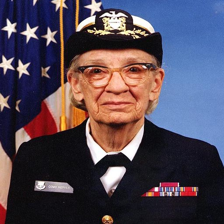

In [6]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model.

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 777ms/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [9]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

##### Decodethe predictions

Take the `predicted_class` ID (such as 653) and fetch the ImageNet dataset labels to decode the predictions:

In [10]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
)
imagenet_labels = np.array(open(labels_path).read().splitlines())

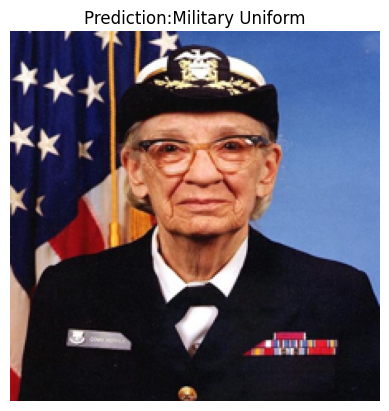

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction:" + predicted_class_name.title())

### Simple transfer learning

To create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

##### Dataset

Using the TensorFlow flowers dataset:

In [12]:
import pathlib

data_file = tf_keras.utils.get_file(
    "flower_photos.tgz",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    cache_dir=".",
    extract=True
)
data_rooot = pathlib.Path(data_file).with_suffix("")

Loading this data into the model using the image data of disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [13]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf_keras.utils.image_dataset_from_directory(
    str(data_rooot),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf_keras.utils.image_dataset_from_directory(
    str(data_rooot),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


The flowers data has five classes:

In [14]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Second, because TensorFlow Hub's convertion for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

In [15]:
normalization_layer = tf_keras.layers.Rescaling(1./255)
# Where x-images, y-labels
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# Where x-images, y-labels
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yeild the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. 

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


2025-04-14 21:07:53.822578: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


##### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [18]:
result_batch = classifier.predict(train_ds)

92/92 [==============================] - 62s 657ms/step


In [19]:
predicted_class_name = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_name

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

Check how these predictions line up with the images:

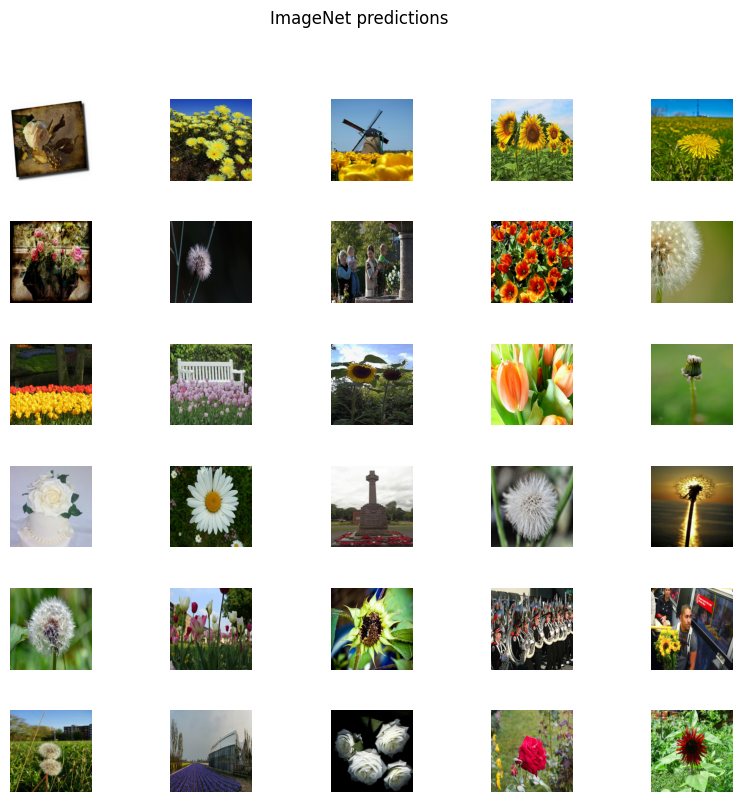

In [20]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.axis("off")
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonalbe considering that these are not the classes the model was trained for (except for "daisy").

##### Dowmload the headless model

TensorFlow hub also distirbutes models without the top classification layer. These can be used to easily perform transfer learning.


In [21]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [22]:
feature_extract_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
)

The feature extractore returns a 1280-long vector for each image (the image batch size remains at 32 in this examples):

In [23]:
feature_batch = feature_extract_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


##### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` (`tf_keras.Sequential`) model and add a fully-connected layer for classification:

In [24]:
num_classes = len(class_names)

model = tf_keras.Sequential([
    feature_extract_layer,
    tf_keras.layers.Dense(num_classes)
])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [26]:
predictions = model(image_batch)

In [27]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use `Model.compile` to configure the configure the training process and add a   `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [28]:
model.compile(
    optimizer = tf_keras.optimizers.Adam(),
    loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf_keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1        # Enable histogram computation for every epoch.
)

In [29]:
NUM_EPOCHS = 10

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=NUM_EPOCHS, 
    callbacks=tensorboard_callback
)

Epoch 1/10
92/92 [==============================] - 74s 769ms/step - loss: 0.6958 - acc: 0.7463 - val_loss: 0.4409 - val_acc: 0.8515
Epoch 2/10
92/92 [==============================] - 74s 809ms/step - loss: 0.3618 - acc: 0.8781 - val_loss: 0.3602 - val_acc: 0.8747
Epoch 3/10
92/92 [==============================] - 65s 712ms/step - loss: 0.2875 - acc: 0.9063 - val_loss: 0.3284 - val_acc: 0.8883
Epoch 4/10
92/92 [==============================] - 65s 713ms/step - loss: 0.2407 - acc: 0.9247 - val_loss: 0.3128 - val_acc: 0.8937
Epoch 5/10
92/92 [==============================] - 65s 704ms/step - loss: 0.2069 - acc: 0.9411 - val_loss: 0.3039 - val_acc: 0.8978
Epoch 6/10
92/92 [==============================] - 64s 693ms/step - loss: 0.1808 - acc: 0.9527 - val_loss: 0.2980 - val_acc: 0.8965
Epoch 7/10
92/92 [==============================] - 63s 692ms/step - loss: 0.1597 - acc: 0.9584 - val_loss: 0.2937 - val_acc: 0.8992
Epoch 8/10
92/92 [==============================] - 64s 694ms/step - 

In [30]:
%tensorboard --logdir logs/fit

### Check the predictions

In [31]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 2s 2s/step
['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


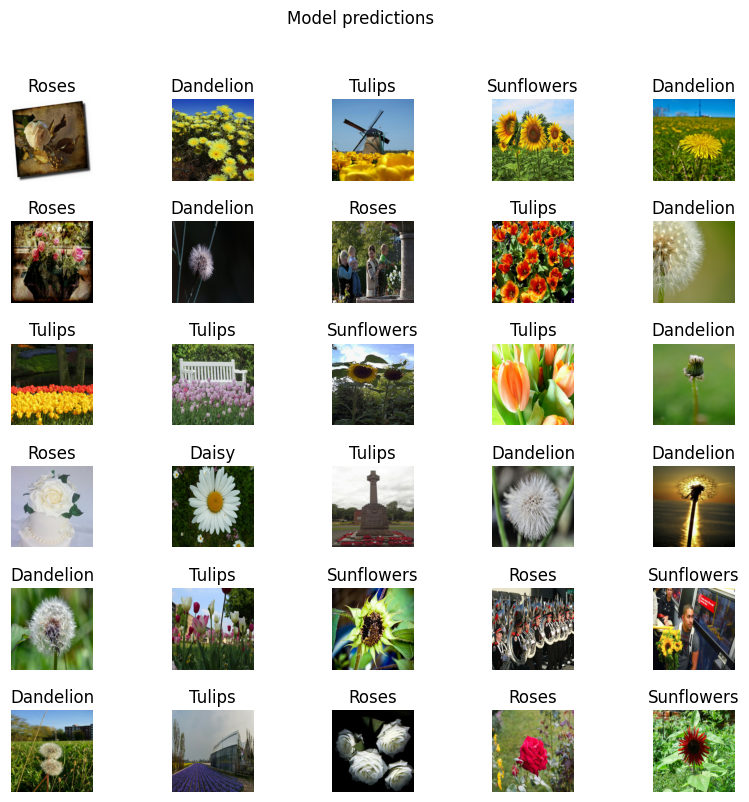

In [32]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

### Export and reload your model

In [33]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1744649080/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1744649080/assets


'/tmp/saved_models/1744649080'

In [35]:
reloaded = tf_keras.models.load_model(export_path)

In [37]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 1s 1s/step


In [38]:
abs(reloaded_result_batch - result_batch).max()

np.float32(0.0)

In [39]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


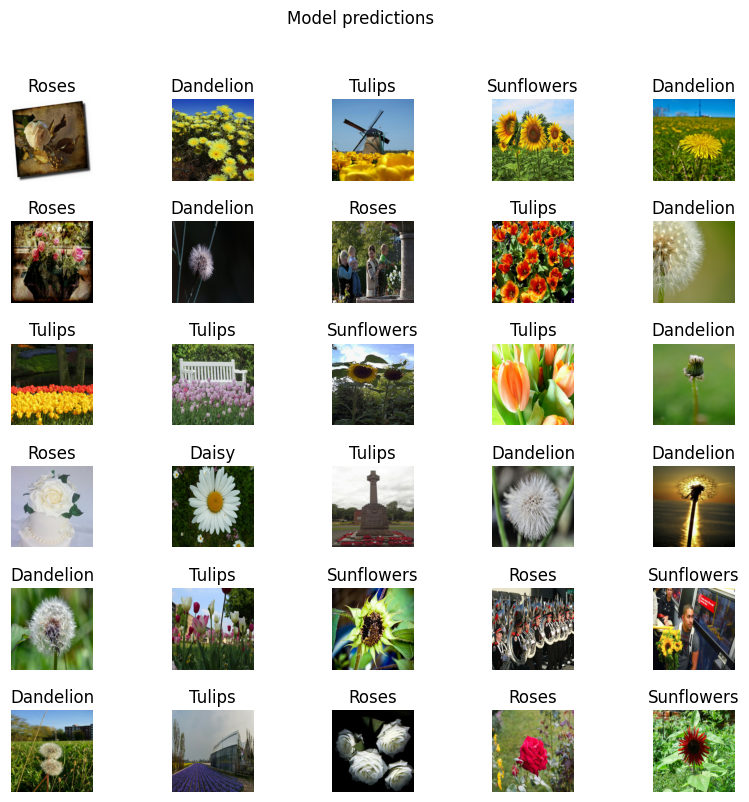

In [40]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(reloaded_predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")